In [ ]:
%%capture

from pyvis.network import Network
import pandas as pd
import numpy as np
import ast
import networkx as nx
import matplotlib.pyplot as plt

from networkx.algorithms import centrality 
from networkx.algorithms.link_analysis.pagerank_alg import pagerank
import os

# check if this is a colab notebook and clone the repo if it is
if 'COLAB_GPU' in os.environ:
    %cd /content/
    !git clone https://github.com/Enver-group/twitch-web-analytics
    %cd twitch-web-analytics
    !gdown --id 11IfXaA66-D7vjA2R46uAilBgOPxYmKmn
# else:
#    os.chdir('..')

!pip install -r requirements.txt

!pip install -e .
#autoreload modules
%load_ext autoreload
%autoreload 2

from src.user import User

In [ ]:
!pip install pyVis

In [ ]:
from IPython.display import display
def get_k_common_followers(filename,filter_weight = 0.05,common_followers_with = "Ibai"):

    if filename.endswith("csv"):
        df = pd.read_csv(filename,lineterminator='\n')
    elif filename.endswith("feather"):
        df = pd.read_feather(filename)

   df = df.dropna(how='any',
                    subset=['user_follows'])


    follows_of_user = df.loc[df.name.str.lower()==common_followers_with.lower()].iloc[0]["user_follows"]

    df = df.loc[df['id'].isin(list(map(int,ast.literal_eval(follows_of_user))))]

    weigths = [np.round(len(list(set(df['id']).intersection(list(map(int,ast.literal_eval(df["user_follows"].values[i]))))))/len(df),2) for i in range(len(df))]

    print(len(weigths))
    df1 = pd.DataFrame({
        "source": [common_followers_with]*len(df),
        "target": df["name"],
        "edge_weights":weigths,
    }).reset_index().drop("index",axis = 1).sort_values("edge_weights",ascending = False)


    df1 = df1[df1.edge_weights > filter_weight]  # remove users without common folloers with Ibai

    display(df1)

    return df1



def plot_graph_pyVis(df,output_file):

  ''' df needs to contain three columns: starting node, ending node and the edge weigth'''

  got_net = Network(height='750px', width='100%', bgcolor='#222222', font_color='white')

  # set the physics layout of the network
  got_net.barnes_hut()

  sources, targets, weigths = df.iloc[:,0],df.iloc[:,1],df.iloc[:,2]

  edge_data = zip(sources, targets,weigths)

  for e in edge_data:
      src = e[0]
      dst = e[1]
      w = e[2]

      got_net.add_node(src, src, title=src)
      got_net.add_node(dst, dst, title=dst)
      got_net.add_edge(src, dst, value=w)

  neighbor_map = got_net.get_adj_list()

  # add neighbor data to node hover data
  for node in got_net.nodes:
      node['title'] += ' Neighbors:<br>' + '<br>'.join(neighbor_map[node['id']])
      node['value'] = len(neighbor_map[node['id']])


  got_net.show_buttons(filter_=['physics'])
  got_net.show(output_file)

def plot_top_followers(filename, k = 15,common_followers_with = "Ibai"):

    if filename.endswith("csv"):
        df = pd.read_csv(filename,lineterminator='\n')
    elif filename.endswith("feather"):
        df = pd.read_feather(filename)

    follows_of_user = df.loc[df.name.str.lower()==common_followers_with.lower()].iloc[0]["user_follows"]

    df = df.loc[df['id'].isin(list(map(int,ast.literal_eval(follows_of_user))))]

    df = df.dropna(how='any',
                            subset=['user_follows'])

    df = df[:k] if k < len(df) else df

    id_names = dict(zip(df["id"],df["name"].values.tolist()))


    df["followers_id"] = [list(set(df["id"]).intersection(list(map(int,ast.literal_eval(df["user_follows"].values[i]))))) for i in range(len(df))]

    def double(j): 
      return id_names[j]


    df["followers_name"] = df["followers_id"].apply(lambda x : list(map(double, x)))


    df = df[['name',"followers_name"]]

    df2 = pd.DataFrame({
        "source":[common_followers_with]*len(df),
        "target":df["name"],
        "edge_weigth":1,
        
    })

    for row in df.iterrows():
      for j in row[1].followers_name:
          
          df2 = df2.append({'source': row[1].values[0], 'target': j, 'edge_weigth': 1}, ignore_index = True)

    display(df2)

    return df2


def networkx_centrality_measures(df):

  G = nx.from_pandas_edgelist(df, edge_attr=True)
 
  eigenvector_centrality = nx.eigenvector_centrality_numpy(G)

  betweenness_centrality = nx.betweenness_centrality(G)

  degree_centrality = nx.degree_centrality(G)

  degree_coefficient = nx.clustering(G)

  df_centrality_measures = pd.DataFrame({
      "eigenvector":eigenvector_centrality,
      "betweenness":betweenness_centrality,
      "degree":degree_centrality,
      "degree_coefficient":degree_coefficient,
  })

  return df_centrality_measures,G


def draw_graph(G,title=None):
  pos = nx.spring_layout(G)
  nx.draw_networkx(G, pos)
  plt.title(title)
  plt.show()



For each user followed by Ibai we have a list of users he follows. The edge_weigths attributes of the following dataset represent the percentage of "similarity" between users followed by Ibai and all the users followed by those followed by Ibai. 

In [ ]:
df = get_k_common_followers("../data/streamers.feather")

plot_graph_pyVis(df,"ibai_common_followers.html")


IndexError: single positional indexer is out-of-bounds

For the following dataframe, we have extracted the 15 most popular users followed by Ibai and for each of them filtered all their followers that are one of those 15 top users. Then, we have created a graph with this information.

In [ ]:
df2 = plot_top_followers("../data/data_ibai.csv")

plot_graph_pyVis(df2,"ibai_top_followers.html")

,source,target,edge_weigth
0,Ibai,auronplay,1
1,Ibai,Rubius,1
2,Ibai,TheGrefg,1
3,Ibai,Ibai,1
4,Ibai,juansguarnizo,1
...,...,...,...
152,LOLITOFDEZ,Alexby11,1
153,LOLITOFDEZ,elded,1
154,LOLITOFDEZ,Rubius,1
155,LOLITOFDEZ,TheGrefg,1


,eigenvector,betweenness,degree,degree_coefficient
Ibai,0.707107,1.0,1.000000,0
malaso,0.060634,0.0,0.007353,0
DarkozTV,0.060634,0.0,0.007353,0
Hydr4G,0.060634,0.0,0.007353,0
Bubbles26,0.060634,0.0,0.007353,0
...,...,...,...,...
danizvfx,0.060634,0.0,0.007353,0
coscu,0.060634,0.0,0.007353,0
Ianbisio,0.060634,0.0,0.007353,0
Apoka,0.060634,0.0,0.007353,0


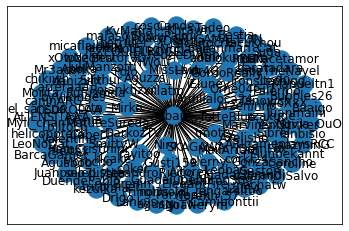

In [ ]:
df1_centrality,G1 = networkx_centrality_measures(df)

display(df1_centrality)

draw_graph(G1)

,eigenvector,betweenness,degree,degree_coefficient
Ibai,0.311847,0.025219,1.142857,0.824176
auronplay,0.253666,0.016833,0.857143,0.848485
Rubius,0.288340,0.025219,1.000000,0.824176
TheGrefg,0.288340,0.025219,1.000000,0.824176
juansguarnizo,0.260191,0.006738,0.857143,0.909091
elded,0.278205,0.008736,0.928571,0.897436
SLAKUN10,0.134449,0.000999,0.428571,0.933333
coscu,0.235481,0.012987,0.785714,0.854545
Robleis,0.278205,0.008736,0.928571,0.897436
Alexby11,0.224520,0.001998,0.714286,0.955556


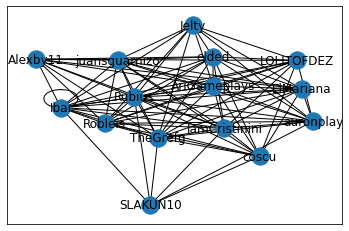

In [ ]:
df2_centrality,G2 = networkx_centrality_measures(df2)

display(df2_centrality)

draw_graph(G2)

  